In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# ---------------------------
# Cargar y limpiar datos
# ---------------------------
df_train = pd.read_parquet("../../data/train/train_sin_outliers.parquet")
cols_drop = [
    "media_diff_1h", "media_diff_45m", "media_diff_20m", "media_diff_10m", "media_diff_5m",
    "despegues_previos_1h", "despegues_previos_45m", "despegues_previos_20m", "despegues_previos_10m", "despegues_previos_5m",
    # 'distancias_holdings_0', 'distancias_holdings_1', 'distancias_holdings_2', 'distancia_en_pista_0', 'distancia_en_pista_1',
    # 'distancia_yendo_a_pista_0', 'distancia_yendo_a_pista_1', 'distancia_yendo_a_pista_2',
    # 'tiempo_holding_0', 'tiempo_holding_1', 'tiempo_holding_2',
    "temp", "wind_shear"
]
df_train.drop(columns=cols_drop, inplace=True)
df_train.dropna(inplace=True)
# Extraer día para split por grupos
if 'ts' in df_train.columns:
    df_train['day'] = pd.to_datetime(df_train['ts']).dt.date
else:
    df_train['day'] = np.random.randint(1, 10, size=len(df_train))

target = 'tiempo_hasta_despegue'
features = [c for c in df_train.columns if c not in (target, 'day', 'ts')]

X_train = df_train[features]
y_train = df_train[target]

# Aplicar log1p a la variable respuesta
y_train_log = np.log1p(y_train)

# ---------------------------
# Definir segmentación
# ---------------------------
def assign_segment(row):
    if (row['holding_ocupado']==0 and row['pista_ocupada']==0 and row['en_camino_antes']==0): return 'todo_libre'
    elif (row['holding_ocupado']==0 and row['pista_ocupada']==1 and row['en_camino_antes']==0): return 'solo_pista'
    elif (row['holding_ocupado']==1 and row['pista_ocupada']==0 and row['en_camino_antes']==0): return 'solo_holding'
    elif (row['holding_ocupado']==0 and row['pista_ocupada']==0 and row['en_camino_antes']==1): return 'solo_camino'
    else: return 'multiple'

# ---------------------------
# Preparar datos segmentados
def create_segmented_data(df):
    df = df.copy().reset_index(drop=True)
    df['segment'] = df.apply(assign_segment, axis=1)
    segments = {}
    for seg in df['segment'].unique():
        sub = df[df['segment']==seg]
        segments[seg] = {
            'X': sub.drop(columns=[target, 'segment', 'runway']),
            'y': sub[target],
            'count': len(sub)
        }

    return segments

train_segments = {}
for runway in X_train['runway'].unique():
    df_r = pd.concat([X_train, y_train], axis=1)
    df_r = df_r[df_r['runway']==runway]
    train_segments[f'runway_{int(runway)}'] = create_segmented_data(df_r)

# ---------------------------
# Grid Search: parámetros ampliados
# ---------------------------
param_grid = {
    'n_estimators':    [50, 100, 200, 300],
    'max_depth':       [2, 3, 4, 5, 6],
    'learning_rate':   [0.01, 0.05, 0.1, 0.2],
    'subsample':       [0.8, 0.9, 1.0]
}

# ---------------------------
# Entrenar modelos con GridSearchCV en log-space
# ---------------------------
models = {}
for runway, segs in train_segments.items():
    models[runway] = {}
    for seg_name, data in segs.items():
        if data['count'] > 100:
            print(f"GridSearch para {runway}-{seg_name} ({data['count']} muestras)...")
            tscv = TimeSeriesSplit(n_splits=3) 
            gs = GridSearchCV(
                GradientBoostingRegressor(random_state=42),
                param_grid, cv=tscv, scoring='neg_mean_absolute_error', n_jobs=-1)
            gs.fit(data['X'], data['y'])
            models[runway][seg_name] = gs.best_estimator_
            print(f"  Mejor params: {gs.best_params_}")
        else:
            print(f"Insuficientes datos para {runway}-{seg_name}: {data['count']} muestras")
            models[runway][seg_name] = None

# Modelo general log-space
print("Entrenando modelo general (log-space)...")
tscv = TimeSeriesSplit(n_splits=3) 
gs_general = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    param_grid, cv=tscv, scoring='neg_mean_absolute_error', n_jobs=-1)
gs_general.fit(X_train, y_train_log)
general_model = gs_general.best_estimator_
print(f"Mejores params (general): {gs_general.best_params_}\n")

GridSearch para runway_3-solo_pista (17725 muestras)...
  Mejor params: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
GridSearch para runway_3-todo_libre (5795 muestras)...
  Mejor params: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 200, 'subsample': 0.9}
GridSearch para runway_3-solo_holding (661 muestras)...
  Mejor params: {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 100, 'subsample': 0.8}
GridSearch para runway_3-solo_camino (2827 muestras)...
  Mejor params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.9}
GridSearch para runway_3-multiple (5574 muestras)...
  Mejor params: {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 100, 'subsample': 1.0}
GridSearch para runway_2-solo_camino (491 muestras)...
  Mejor params: {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 200, 'subsample': 1.0}
GridSearch para runway_2-solo_pista (7861 muestras)...
  Mejor params: {'learning_rate': 0.01, 'max

=== Métricas Globales ===
MAE:  65.91
RMSE: 92.48
R²:   0.16

=== Métricas por Segmento ===
                    MAE   Count
segment                        
multiple      79.906650  1786.0
solo_camino   65.920790   802.0
solo_holding  86.779718   269.0
solo_pista    55.182621  7224.0
todo_libre    81.703038  2971.0 

=== Métricas por Pista ===
              MAE   Count
runway                   
0.0     61.014474  1319.0
1.0     81.268226  3802.0
2.0     55.391471  2810.0
3.0     61.549414  5121.0 

=== Métricas por Holding Point ===
                      MAE   Count
holding_point                    
0.0             72.681712    31.0
2.0             54.144078  1158.0
3.0            110.430120   161.0
4.0             56.704763  1651.0
5.0             64.136004   582.0
6.0             42.813373   577.0
7.0             61.985857  2237.0
8.0             58.607928  2360.0
9.0             72.949986   493.0
10.0            66.142045  1400.0
11.0            87.872115  1241.0
12.0           116.4

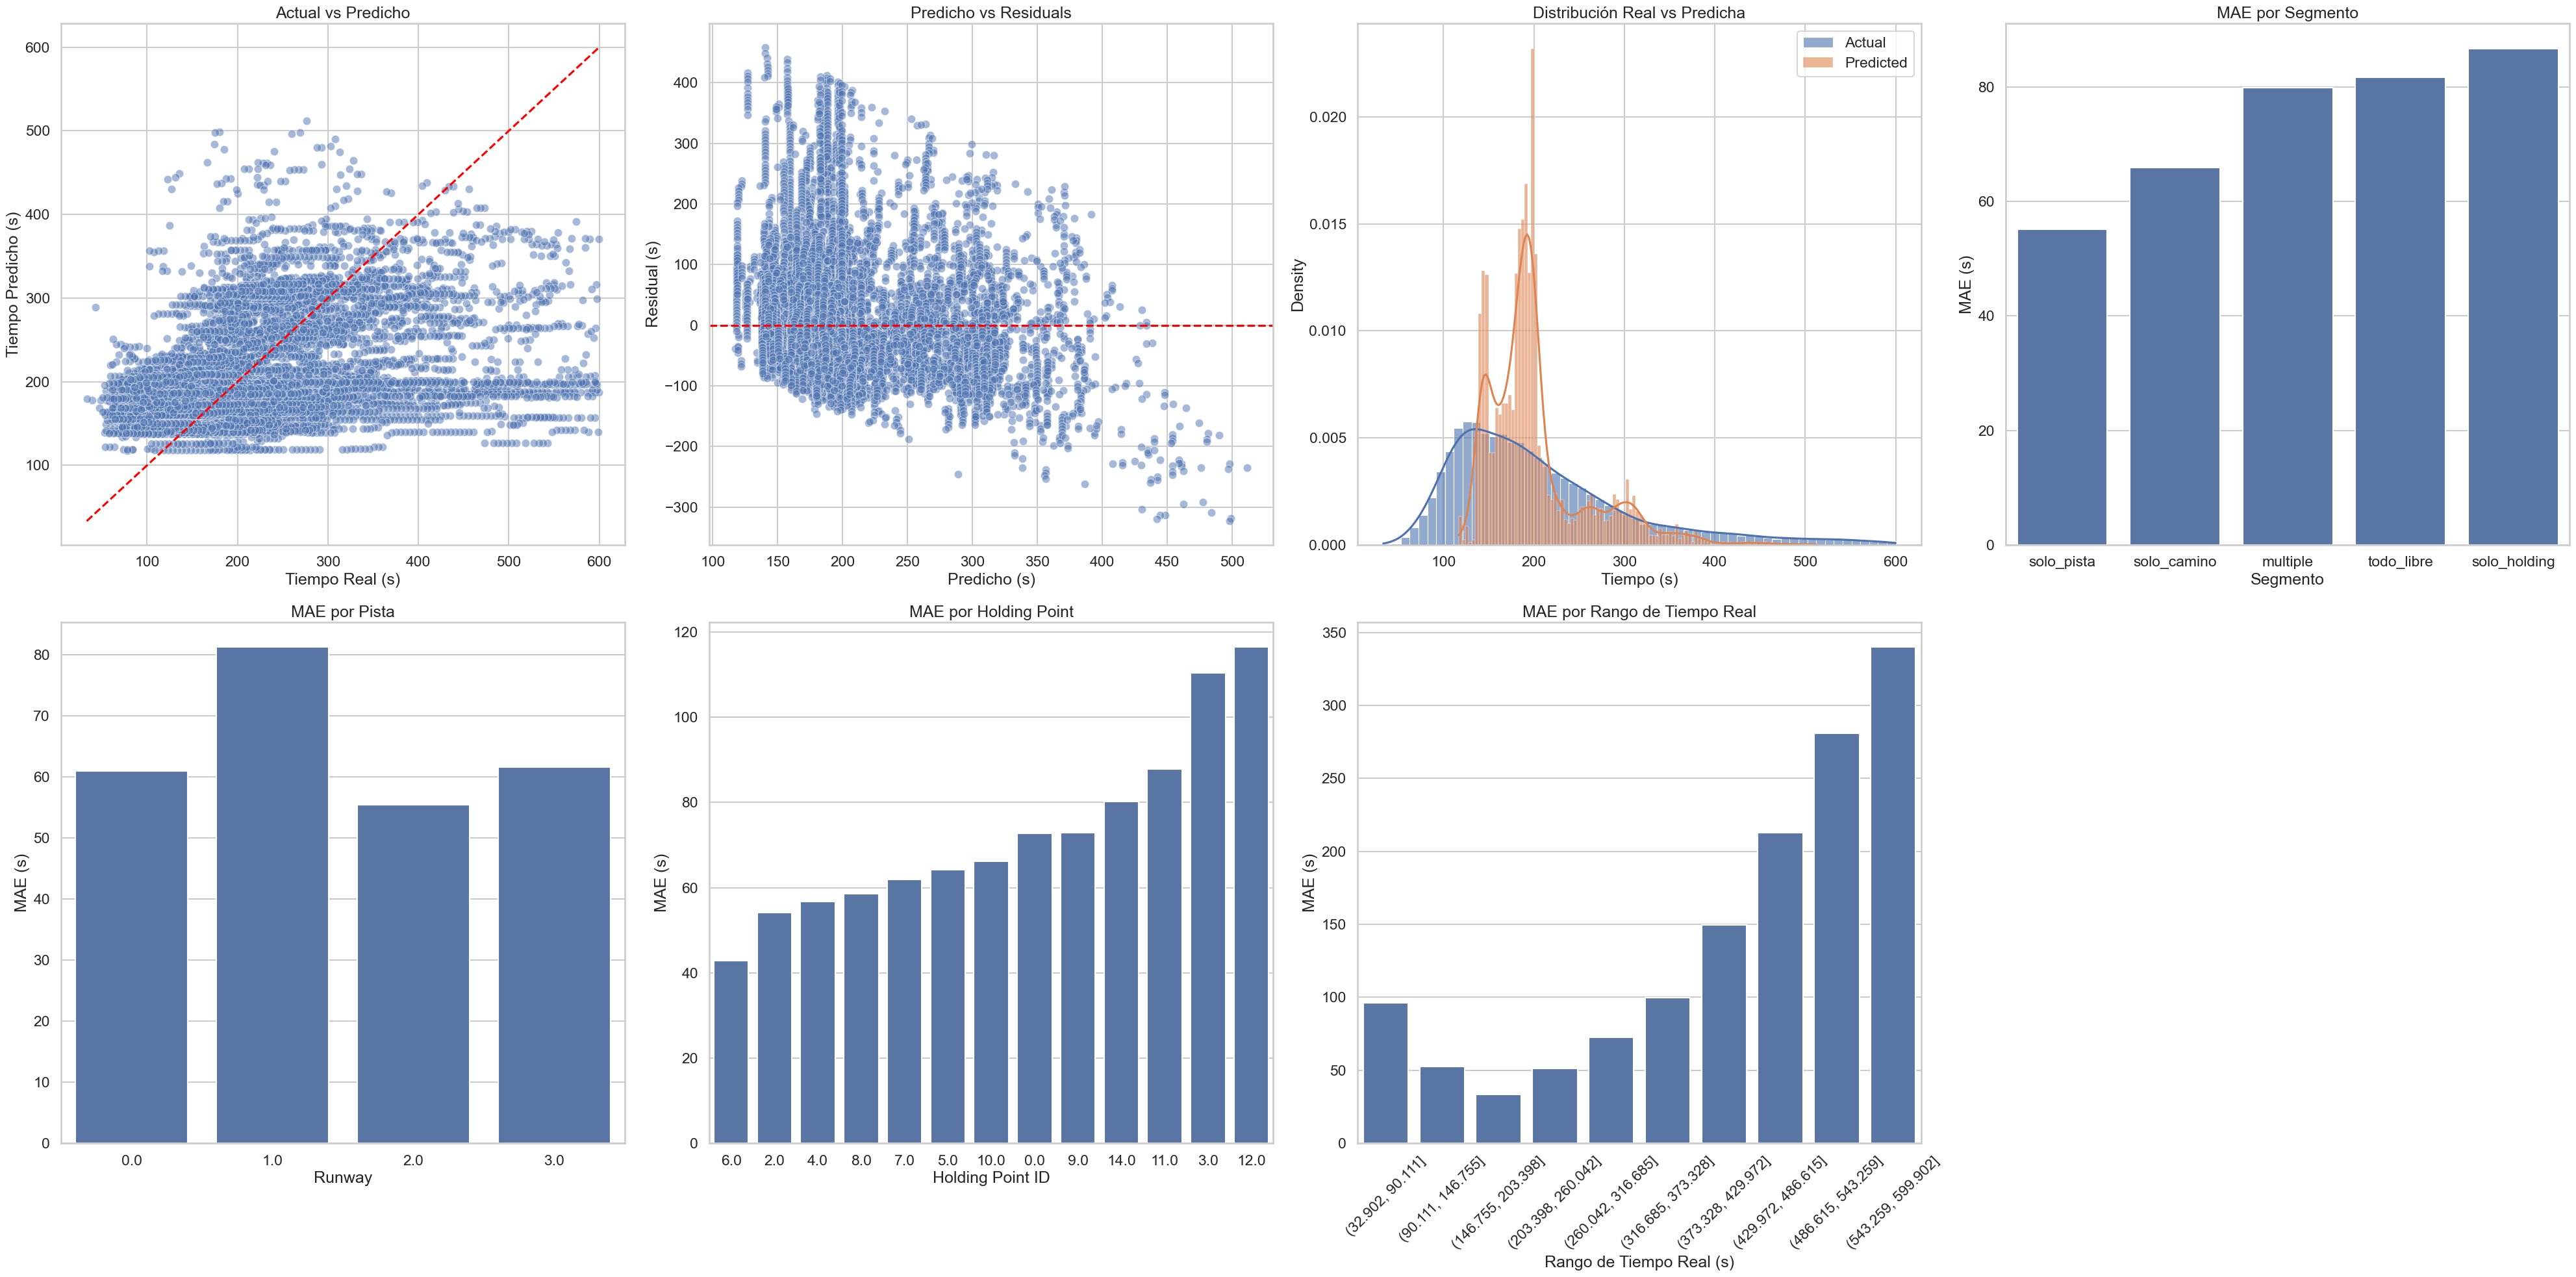

In [26]:
# ---------------------------
# Función de predicción e inversa de log
# ---------------------------
def predict_by_segment(X, y, models, general_model):
    df = pd.concat([X.reset_index(drop=True), y.reset_index(drop=True)], axis=1)
    df['segment'] = df.apply(assign_segment, axis=1)
    results = []
    for _, row in df.iterrows():
        key = f"runway_{int(row['runway'])}"
        seg = row['segment']
        model = models.get(key, {}).get(seg) or general_model
        X_row = row.drop([target, 'segment', "runway"]).values.reshape(1, -1)
        try: 
            pred = model.predict(X_row)[0]
            results.append({
                'actual': row[target], 'predicted': pred,
                'runway': row['runway'], 'segment': seg,
                'holding_point': row['holding_point_id'] if 'holding_point_id' in row.index else None
            })
        except:
            pass

    return pd.DataFrame(results)

# ---------------------------
# 1) Carga y predicción
# ---------------------------
df_test = pd.read_parquet("../../data/test/test_sin_outliers.parquet").drop(columns=["ts"]).dropna()
df_test = df_test.drop(columns=cols_drop, errors='ignore')

if target in df_test.columns:
    X_test = df_test.drop(columns=[target])
    y_test = df_test[target]
else:
    X_test = df_test
    y_test = pd.Series([np.nan] * len(df_test))

test_results = predict_by_segment(X_test, y_test, models, general_model)

# ---------------------------
# 2) Cálculo de métricas
# ---------------------------
# Globales
mae   = mean_absolute_error(test_results.actual,    test_results.predicted)
rmse  = np.sqrt(     mean_squared_error(test_results.actual, test_results.predicted))
r2    = r2_score(    test_results.actual,    test_results.predicted)

# Por segmento
seg_metrics    = test_results.groupby('segment').apply(
    lambda df: pd.Series({'MAE': mean_absolute_error(df.actual, df.predicted), 'Count': len(df)})
)
# Por pista (runway)
runway_metrics = test_results.groupby('runway').apply(
    lambda df: pd.Series({'MAE': mean_absolute_error(df.actual, df.predicted), 'Count': len(df)})
)
# Por holding_point (si existe)
if test_results['holding_point'].notna().any():
    hp_metrics = test_results.groupby('holding_point').apply(
        lambda df: pd.Series({'MAE': mean_absolute_error(df.actual, df.predicted), 'Count': len(df)})
    )
else:
    hp_metrics = None
# Por rango de tiempo real
test_results['actual_bin'] = pd.cut(test_results.actual, bins=10)
bin_metrics = test_results.groupby('actual_bin').apply(
    lambda df: pd.Series({'MAE': mean_absolute_error(df.actual, df.predicted), 'Count': len(df)})
)

# ---------------------------
# 3) Impresión de resultados
# ---------------------------
print("=== Métricas Globales ===")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.2f}\n")

print("=== Métricas por Segmento ===")
print(seg_metrics, "\n")

print("=== Métricas por Pista ===")
print(runway_metrics, "\n")

if hp_metrics is not None:
    print("=== Métricas por Holding Point ===")
    print(hp_metrics, "\n")

print("=== Métricas por Rango de Tiempo Real ===")
print(bin_metrics, "\n")

# ---------------------------
# 4) Gráficas con seaborn
# ---------------------------
sns.set(style="whitegrid", context="talk")
rows, cols = 2, 4
fig, axs = plt.subplots(rows, cols, figsize=(40, 20))
axs = axs.flatten()

# 1) Actual vs Predicho
sns.scatterplot(x="actual", y="predicted", data=test_results, ax=axs[0], alpha=0.5)
axs[0].plot(
    [test_results.actual.min(), test_results.actual.max()],
    [test_results.actual.min(), test_results.actual.max()],
    '--', color='red'
)
axs[0].set_title('Actual vs Predicho')
axs[0].set_xlabel('Tiempo Real (s)')
axs[0].set_ylabel('Tiempo Predicho (s)')

# 2) Predicho vs Residuals
test_results["residual"] = test_results["actual"] - test_results["predicted"]
sns.scatterplot(x="predicted", y="residual", data=test_results, ax=axs[1], alpha=0.5)
axs[1].axhline(0, linestyle='--', color='red')
axs[1].set_title('Predicho vs Residuals')
axs[1].set_xlabel('Predicho (s)')
axs[1].set_ylabel('Residual (s)')

# 3) Distribución Real vs Predicha con bins
sns.histplot(test_results["actual"], kde=True, stat="density", alpha=0.6, label='Actual', ax=axs[2])
sns.histplot(test_results["predicted"], kde=True, stat="density", alpha=0.6, label='Predicted', ax=axs[2])
axs[2].set_title('Distribución Real vs Predicha')
axs[2].set_xlabel('Tiempo (s)')
axs[2].legend()

# 4) MAE por Segmento
seg_order = seg_metrics["MAE"].sort_values().index
sns.barplot(x=seg_metrics.loc[seg_order].index, y=seg_metrics.loc[seg_order]["MAE"], ax=axs[3])
axs[3].set_title('MAE por Segmento')
axs[3].set_xlabel('Segmento')
axs[3].set_ylabel('MAE (s)')

# 5) MAE por Pista
sns.barplot(x=runway_metrics.index.astype(str), y=runway_metrics["MAE"], ax=axs[4])
axs[4].set_title('MAE por Pista')
axs[4].set_xlabel('Runway')
axs[4].set_ylabel('MAE (s)')

# 6) MAE por Holding Point
if hp_metrics is not None:
    hp_order = hp_metrics["MAE"].sort_values().index
    sns.barplot(x=hp_order.astype(str), y=hp_metrics.loc[hp_order]["MAE"], ax=axs[5])
    axs[5].set_title('MAE por Holding Point')
    axs[5].set_xlabel('Holding Point ID')
    axs[5].set_ylabel('MAE (s)')
else:
    axs[5].axis('off')

# 7) MAE por Rango de Tiempo Real
sns.barplot(x=bin_metrics.index.astype(str), y=bin_metrics["MAE"], ax=axs[6])
axs[6].set_title('MAE por Rango de Tiempo Real')
axs[6].set_xlabel('Rango de Tiempo Real (s)')
axs[6].set_ylabel('MAE (s)')
axs[6].tick_params(axis='x', rotation=45)

# Ocultar ejes vacíos
for ax in axs[7:]:
    ax.axis('off')

plt.tight_layout()
plt.show()


=== Métricas Globales ===
MAE:  71.10
RMSE: 105.15
R²:   0.15

=== Métricas por Segmento ===
                    MAE   Count
segment                        
multiple      90.878089  1857.0
solo_camino   73.088247   817.0
solo_holding  99.237178   278.0
solo_pista    59.535131  7301.0
todo_libre    83.895062  2988.0 

=== Métricas por Pista ===
              MAE   Count
runway                   
0.0     69.778268  1347.0
1.0     88.889849  3886.0
2.0     58.094042  2827.0
3.0     65.191459  5181.0 

=== Métricas por Holding Point ===
                      MAE   Count
holding_point                    
0.0             72.509919    31.0
2.0             57.202307  1165.0
3.0            150.278237   182.0
4.0             61.184422  1668.0
5.0             64.073855   582.0
6.0             43.128693   577.0
7.0             66.542228  2268.0
8.0             62.202469  2389.0
9.0             73.001355   493.0
10.0            71.065600  1419.0
11.0            97.692400  1278.0
12.0           134.

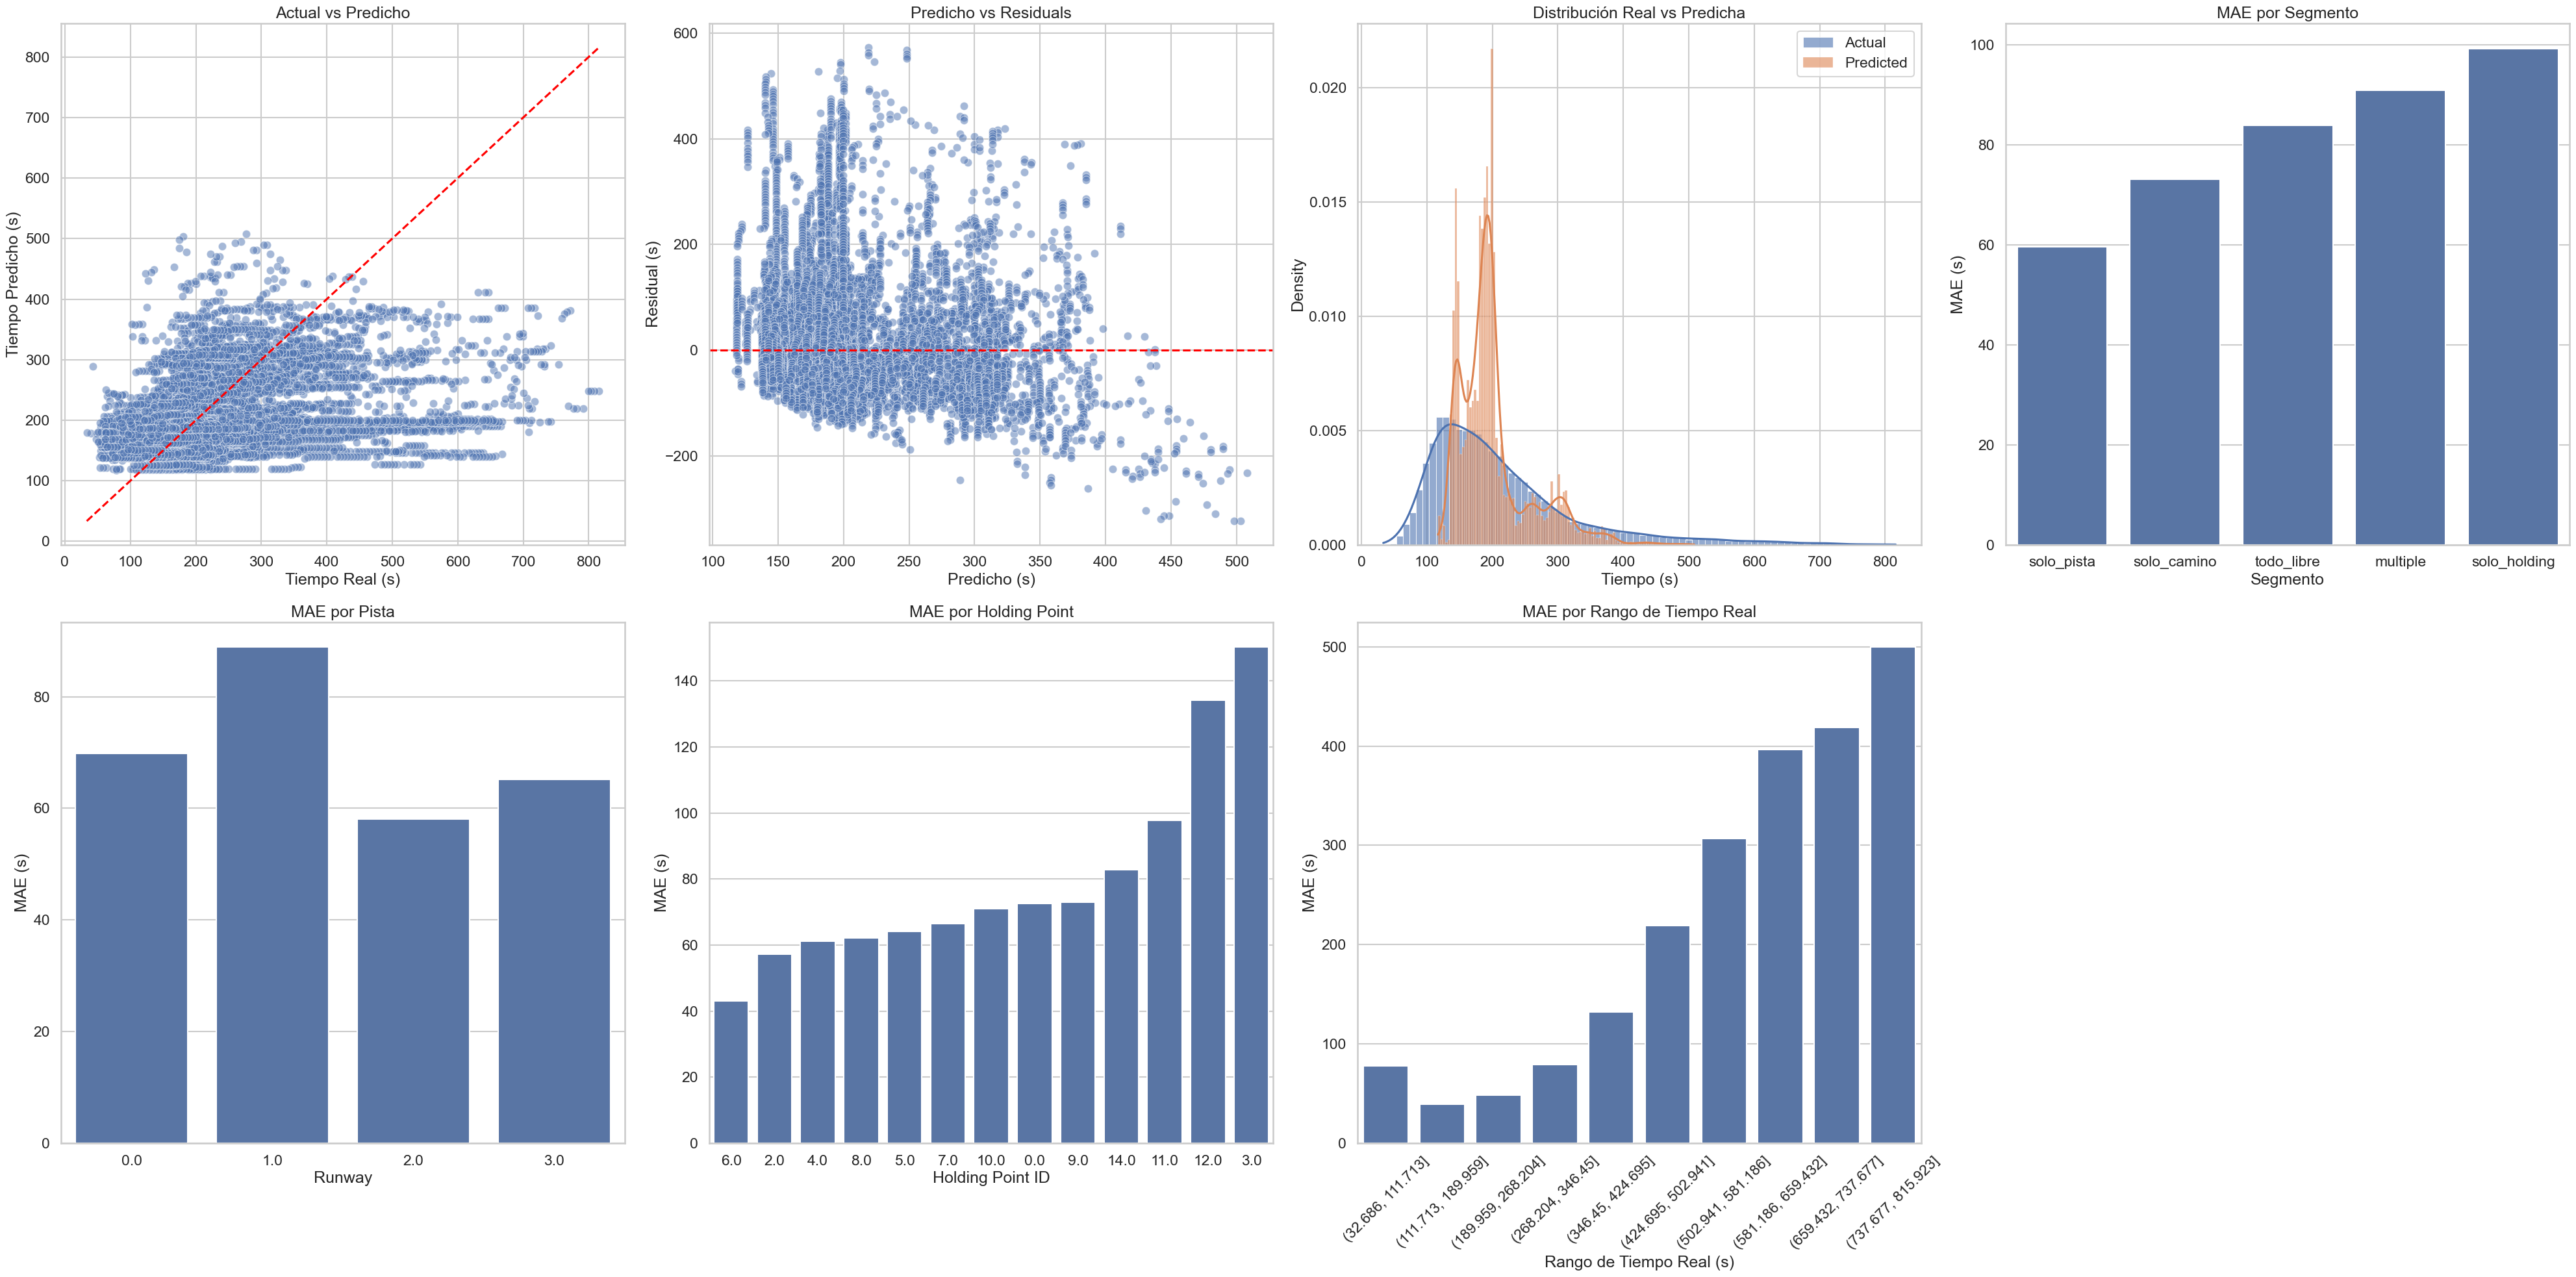

In [29]:
# ---------------------------
# Función de predicción e inversa de log
# ---------------------------
def predict_by_segment(X, y, models, general_model):
    df = pd.concat([X.reset_index(drop=True), y.reset_index(drop=True)], axis=1)
    df['segment'] = df.apply(assign_segment, axis=1)
    results = []
    for _, row in df.iterrows():
        key = f"runway_{int(row['runway'])}"
        seg = row['segment']
        model = models.get(key, {}).get(seg) or general_model
        try:
            X_row = row.drop([target, 'segment', "runway"]).values.reshape(1, -1)
            pred = model.predict(X_row)[0]
            results.append({
                'actual': row[target], 'predicted': pred,
                'runway': row['runway'], 'segment': seg,
                'holding_point': row['holding_point_id'] if 'holding_point_id' in row.index else None
            })
        except:
            pass
    return pd.DataFrame(results)

# ---------------------------
# 1) Carga y predicción
# ---------------------------
df_test = pd.read_parquet("../../data/test/test_con_outliers.parquet").drop(columns=["ts"]).dropna()
df_test = df_test.drop(columns=cols_drop, errors='ignore')

if target in df_test.columns:
    X_test = df_test.drop(columns=[target])
    y_test = df_test[target]
else:
    X_test = df_test
    y_test = pd.Series([np.nan] * len(df_test))

test_results = predict_by_segment(X_test, y_test, models, general_model)

# ---------------------------
# 2) Cálculo de métricas
# ---------------------------
# Globales
mae   = mean_absolute_error(test_results.actual,    test_results.predicted)
rmse  = np.sqrt(     mean_squared_error(test_results.actual, test_results.predicted))
r2    = r2_score(    test_results.actual,    test_results.predicted)

# Por segmento
seg_metrics    = test_results.groupby('segment').apply(
    lambda df: pd.Series({'MAE': mean_absolute_error(df.actual, df.predicted), 'Count': len(df)})
)
# Por pista (runway)
runway_metrics = test_results.groupby('runway').apply(
    lambda df: pd.Series({'MAE': mean_absolute_error(df.actual, df.predicted), 'Count': len(df)})
)
# Por holding_point (si existe)
if test_results['holding_point'].notna().any():
    hp_metrics = test_results.groupby('holding_point').apply(
        lambda df: pd.Series({'MAE': mean_absolute_error(df.actual, df.predicted), 'Count': len(df)})
    )
else:
    hp_metrics = None
# Por rango de tiempo real
test_results['actual_bin'] = pd.cut(test_results.actual, bins=10)
bin_metrics = test_results.groupby('actual_bin').apply(
    lambda df: pd.Series({'MAE': mean_absolute_error(df.actual, df.predicted), 'Count': len(df)})
)

# ---------------------------
# 3) Impresión de resultados
# ---------------------------
print("=== Métricas Globales ===")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.2f}\n")

print("=== Métricas por Segmento ===")
print(seg_metrics, "\n")

print("=== Métricas por Pista ===")
print(runway_metrics, "\n")

if hp_metrics is not None:
    print("=== Métricas por Holding Point ===")
    print(hp_metrics, "\n")

print("=== Métricas por Rango de Tiempo Real ===")
print(bin_metrics, "\n")

# ---------------------------
# 4) Gráficas con seaborn
# ---------------------------
sns.set(style="whitegrid", context="talk")
rows, cols = 2, 4
fig, axs = plt.subplots(rows, cols, figsize=(40, 20))
axs = axs.flatten()

# 1) Actual vs Predicho
sns.scatterplot(x="actual", y="predicted", data=test_results, ax=axs[0], alpha=0.5)
axs[0].plot(
    [test_results.actual.min(), test_results.actual.max()],
    [test_results.actual.min(), test_results.actual.max()],
    '--', color='red'
)
axs[0].set_title('Actual vs Predicho')
axs[0].set_xlabel('Tiempo Real (s)')
axs[0].set_ylabel('Tiempo Predicho (s)')

# 2) Predicho vs Residuals
test_results["residual"] = test_results["actual"] - test_results["predicted"]
sns.scatterplot(x="predicted", y="residual", data=test_results, ax=axs[1], alpha=0.5)
axs[1].axhline(0, linestyle='--', color='red')
axs[1].set_title('Predicho vs Residuals')
axs[1].set_xlabel('Predicho (s)')
axs[1].set_ylabel('Residual (s)')

# 3) Distribución Real vs Predicha con bins
sns.histplot(test_results["actual"], kde=True, stat="density", alpha=0.6, label='Actual', ax=axs[2])
sns.histplot(test_results["predicted"], kde=True, stat="density", alpha=0.6, label='Predicted', ax=axs[2])
axs[2].set_title('Distribución Real vs Predicha')
axs[2].set_xlabel('Tiempo (s)')
axs[2].legend()

# 4) MAE por Segmento
seg_order = seg_metrics["MAE"].sort_values().index
sns.barplot(x=seg_metrics.loc[seg_order].index, y=seg_metrics.loc[seg_order]["MAE"], ax=axs[3])
axs[3].set_title('MAE por Segmento')
axs[3].set_xlabel('Segmento')
axs[3].set_ylabel('MAE (s)')

# 5) MAE por Pista
sns.barplot(x=runway_metrics.index.astype(str), y=runway_metrics["MAE"], ax=axs[4])
axs[4].set_title('MAE por Pista')
axs[4].set_xlabel('Runway')
axs[4].set_ylabel('MAE (s)')

# 6) MAE por Holding Point
if hp_metrics is not None:
    hp_order = hp_metrics["MAE"].sort_values().index
    sns.barplot(x=hp_order.astype(str), y=hp_metrics.loc[hp_order]["MAE"], ax=axs[5])
    axs[5].set_title('MAE por Holding Point')
    axs[5].set_xlabel('Holding Point ID')
    axs[5].set_ylabel('MAE (s)')
else:
    axs[5].axis('off')

# 7) MAE por Rango de Tiempo Real
sns.barplot(x=bin_metrics.index.astype(str), y=bin_metrics["MAE"], ax=axs[6])
axs[6].set_title('MAE por Rango de Tiempo Real')
axs[6].set_xlabel('Rango de Tiempo Real (s)')
axs[6].set_ylabel('MAE (s)')
axs[6].tick_params(axis='x', rotation=45)

# Ocultar ejes vacíos
for ax in axs[7:]:
    ax.axis('off')

plt.tight_layout()
plt.show()


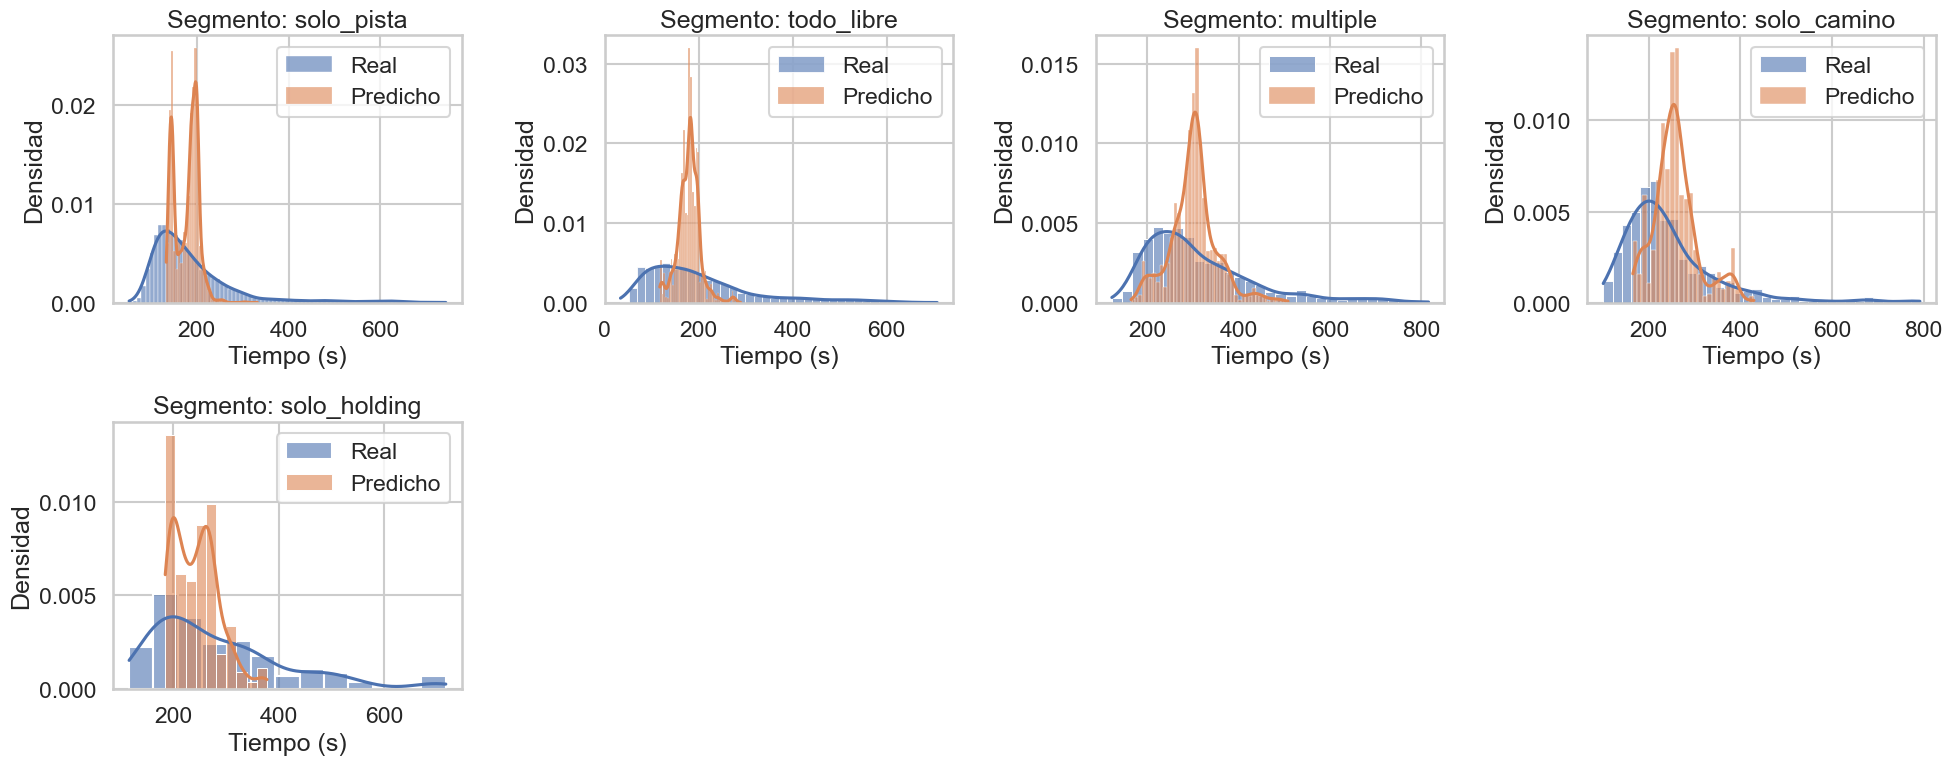

In [30]:
# ---------------------------
# 5) Distribución Real vs Predicha por Segmento
# ---------------------------
segments = test_results['segment'].unique()
n_seg = len(segments)
# Definimos un grid de subplots (4 columnas como ejemplo)
cols = 4
rows = int(np.ceil(n_seg / cols))
fig, axs = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
axs = axs.flatten()

for ax, seg in zip(axs, segments):
    df_seg = test_results[test_results['segment'] == seg]
    # Histograma real
    sns.histplot(
        df_seg["actual"],
        kde=True,
        stat="density",
        alpha=0.6,
        label='Real',
        ax=ax
    )
    # Histograma predicho
    sns.histplot(
        df_seg["predicted"],
        kde=True,
        stat="density",
        alpha=0.6,
        label='Predicho',
        ax=ax
    )
    ax.set_title(f'Segmento: {seg}')
    ax.set_xlabel('Tiempo (s)')
    ax.set_ylabel('Densidad')
    ax.legend()

# Si hay ejes sobrantes, los ocultamos
for ax in axs[n_seg:]:
    ax.axis('off')

plt.tight_layout()
plt.show()
